In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.set_random_seed(1)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
import matplotlib.pyplot as plt
import PIL.Image as Image
import math
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
import json
from tensorflow.keras.losses import mse
import os
import glob
import random
import sys
ros_path = '/opt/ros/kinetic/lib/python2.7/dist-packages'

if ros_path in sys.path:

    sys.path.remove(ros_path)

import cv2

sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
import datetime
from tensorflow.keras.layers import Dense, Input, concatenate, Conv2D, MaxPooling2D, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def add_layer(tensor):
    return tensor[0] + tensor[1]

def mul_layer(tensor):
    return tensor[0] * tensor[1]

def div_layer(tensor):
    return tensor[0] / tensor[1]

def sub_layer(tensor):
    return tensor[0] - tensor[1]

def neg_layer(tensor):
    return -tensor

def cos_layer(tensor):
    return tf.math.cos(tensor)

def sin_layer(tensor):
    return tf.math.sin(tensor)

In [3]:
# feature extraction from left image
left_img = Input(shape = (112,112,3), name="left_image")

# feature extraction from right image
right_img = Input(shape = (112,112,3), name="right_image")

concat = concatenate([left_img, right_img])

phi_model = InceptionV3(weights=None, include_top=False, input_tensor=concat, input_shape=(112,112,6))
phi_features = phi_model.output
flat = Flatten(name='phi-flattened')(phi_features)


# fx
dense_1 = Dense(120, activation = 'relu')(flat)
dense_2 = Dense(84, activation = 'relu', name='dense_fx')(dense_1)
pred_fx = Dense(1, name='fx')(dense_2)

# fy
dense_3 = Dense(120, activation = 'relu')(flat)
dense_4 = Dense(84, activation = 'relu', name='dense_fy')(dense_3)
pred_fy = Dense(1, name='fy')(dense_4)

# u0
dense_5 = Dense(120, activation = 'relu')(flat)
dense_6 = Dense(84, activation = 'relu', name='dense_u0')(dense_5)
pred_u0 = Dense(1, name='u0')(dense_6)

# v0
dense_7 = Dense(120, activation = 'relu')(flat)
dense_8 = Dense(84, activation = 'relu', name='dense_v0')(dense_7)
pred_v0 = Dense(1, name='v0')(dense_8)

# baseline
dense_9 = Dense(120, activation = 'relu')(flat)
dense_10 = Dense(84, activation = 'relu', name='dense_baseline')(dense_9)
pred_baseline = Dense(1, name='baseline')(dense_10)

# tx
dense_11 = Dense(120, activation = 'relu')(flat)
dense_12 = Dense(84, activation = 'relu', name='dense_tx')(dense_11)
pred_x = Dense(1, name='x')(dense_12)

# ty
dense_13 = Dense(120, activation = 'relu')(flat)
dense_14 = Dense(84, activation = 'relu', name='dense_ty')(dense_13)
pred_y = Dense(1, name='y')(dense_14)

# tz
dense_15 = Dense(120, activation = 'relu')(flat)
dense_16 = Dense(84, activation = 'relu', name='dense_tz')(dense_15)
pred_z = Dense(1, name='z')(dense_16)

# pitch
dense_17 = Dense(120, activation = 'relu')(flat)
dense_18 = Dense(84, activation = 'relu', name='dense_pitch')(dense_17)
pred_pitch = Dense(1, name='pitch')(dense_18)

# u
dense_19 = Dense(120, activation = 'relu')(flat)
dense_20 = Dense(84, activation = 'relu', name='dense_u')(dense_19)
pred_u = Dense(1, name='u')(dense_20)

# v
dense_21 = Dense(120, activation = 'relu')(flat)
dense_22 = Dense(84, activation = 'relu', name='dense_v')(dense_21)
pred_v = Dense(1, name='v')(dense_22)

# disparity
dense_23 = Dense(120, activation = 'relu')(flat)
dense_24 = Dense(84, activation = 'relu', name='dense_disparity')(dense_23)
pred_disparity = Dense(1, name='disparity')(dense_24)

# xCam = (self.intrinsic.fx * self.extrinsic.baseline) / disparity
mul_1 = Lambda(mul_layer)([pred_fx, pred_baseline])
xCam = Lambda(div_layer, name='xCam')([mul_1, pred_disparity])

# yCam = - (xCam / self.intrinsic.fx) * (u - self.intrinsic.u0)
div_1 = Lambda(div_layer)([xCam, pred_fx])
sub_1 = Lambda(sub_layer)([pred_u, pred_u0])
yCam = Lambda(mul_layer, name='yCam')([Lambda(neg_layer)(div_1), sub_1])

# zCam = (xCam / self.intrinsic.fy) * (self.intrinsic.v0 - v)
div_2 = Lambda(div_layer)([xCam, pred_fy])
sub_2 = Lambda(sub_layer)([pred_v0, pred_v])
zCam = Lambda(mul_layer, name='zCam')([div_2, sub_2])

# Y = yCam + self.extrinsic.y
pred_yWorld = Lambda(add_layer, name='yWorld')([yCam, pred_y])

# X = xCam * math.cos(self.extrinsic.pitch) + zCam * math.sin(self.extrinsic.pitch) + self.extrinsic.x
mul_2 = Lambda(mul_layer)([xCam, Lambda(cos_layer)(pred_pitch)])
mul_3 = Lambda(mul_layer)([zCam, Lambda(sin_layer)(pred_pitch)])
add_1 = Lambda(add_layer)([mul_2, mul_3])
pred_xWorld = Lambda(add_layer, name='xWorld')([add_1, pred_x])

# Z = - xCam * math.sin(self.extrinsic.pitch) + zCam * math.cos(self.extrinsic.pitch) + self.extrinsic.z
mul_4 = Lambda(mul_layer)([Lambda(neg_layer)(xCam), Lambda(sin_layer)(pred_pitch)])
mul_5 = Lambda(mul_layer)([zCam, Lambda(cos_layer)(pred_pitch)])
add_2 = Lambda(add_layer)([mul_4, mul_5])
pred_zWorld = Lambda(add_layer, name='zWorld')([add_2, pred_z])

# create model
model = Model(inputs=[left_img, right_img], outputs=[pred_fx, pred_fy, pred_u0, pred_v0, pred_baseline, pred_disparity, pred_x, pred_y, pred_z, pred_pitch, pred_xWorld,pred_yWorld,pred_zWorld])

# set output types
target1 = tf.placeholder(dtype='float32', shape=(1,1)) 
target2 = tf.placeholder(dtype='float32', shape=(1,1))
target3 = tf.placeholder(dtype='float32', shape=(1,1))
target4 = tf.placeholder(dtype='float32', shape=(1,1)) 
target5 = tf.placeholder(dtype='float32', shape=(1,1))
target6 = tf.placeholder(dtype='float32', shape=(1,1))
target7 = tf.placeholder(dtype='float32', shape=(1,1)) 
target8 = tf.placeholder(dtype='float32', shape=(1,1))
target9 = tf.placeholder(dtype='float32', shape=(1,1))
target10 = tf.placeholder(dtype='float32', shape=(1,1)) 
target11 = tf.placeholder(dtype='float32', shape=(1,1))
target12 = tf.placeholder(dtype='float32', shape=(1,1))
target13 = tf.placeholder(dtype='float32', shape=(1,1))

# get model summary
model.summary()

learning_rate = 0.001

# compile model
model.compile(loss="mae", target_tensors=[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13],optimizer=optimizers.Adam(lr=learning_rate))
plot_model(model, to_file='model.png')

/home/talha/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/applications/imagenet_utils.py:331: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 6 input channels.
  warnings.warn('This model usually expects 1 or 3 input channels. '


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_image (InputLayer)         [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
right_image (InputLayer)        [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 112, 112, 6)  0           left_image[0][0]                 
                                                                 right_image[0][0]                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 55, 55, 32)   1728        concatenate[0][0]     

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# Get data

In [4]:
data_path = "../Data/"

Left_images = np.load(data_path+"li.npy")
Right_images = np.load(data_path+"ri.npy")
Fx = np.load(data_path+"fx.npy")
Fy = np.load(data_path+"fy.npy") 
U0 = np.load(data_path+"u0.npy") 
V0 = np.load(data_path+"v0.npy") 
Baseline = np.load(data_path+"b.npy")
Disparity = np.load(data_path+"d.npy") 
Tx = np.load(data_path+"tx.npy") 
Ty = np.load(data_path+"ty.npy") 
Tz = np.load(data_path+"tz.npy") 
Pitch = np.load(data_path+"p.npy")
X = np.load(data_path+"x.npy")
Y = np.load(data_path+"y.npy") 
Z = np.load(data_path+"z.npy")


In [7]:
print ("Training Dataset: ",len(Left_images)*0.7, "Test Dataset: ", len(Left_images)*0.3)

Training Dataset:  55524.0 Test Dataset:  23796.0


In [8]:
import os
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

model_name = 'model_multi_class/'
SAVE = "new_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/'
# Save
output_folder = SAVE + model_name
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_log = output_folder + "Log/"
if not os.path.exists(output_log):
    os.makedirs(output_log)

output_weight = output_folder + "Best/"
if not os.path.exists(output_weight):
    os.makedirs(output_weight)


input_shape = (112, 112, 3)

tensorboard = TensorBoard(log_dir=output_log)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto', restore_best_weights=True)

csv_logger = CSVLogger('training.log')

checkpointer = ModelCheckpoint(
    model_for_saving=model,
    filepath=output_weight + "weights_{epoch:02d}_{val_loss:.2f}.h5",
    save_best_only=True,
    monitor='val_loss',
    save_weights_only=True
)

history = model.fit(
    x=[Left_images[:int(len(Left_images)*0.7)], Right_images[:int(len(Left_images)*0.7)]],
    y=[Fx[:int(len(Left_images)*0.7)], Fy[:int(len(Left_images)*0.7)], U0[:int(len(Left_images)*0.7)], V0[:int(len(Left_images)*0.7)], Baseline[:int(len(Left_images)*0.7)], Disparity[:int(len(Left_images)*0.7)], Tx[:int(len(Left_images)*0.7)], Ty[:int(len(Left_images)*0.7)], Tz[:int(len(Left_images)*0.7)], Pitch[:int(len(Left_images)*0.7)], X[:int(len(Left_images)*0.7)], Y[:int(len(Left_images)*0.7)], Z[:int(len(Left_images)*0.7)]],
    batch_size=16,
    epochs=200,
    verbose=1,
    shuffle=True,
    initial_epoch=0,
    validation_data=([Left_images[int(len(Left_images)*0.7):], Right_images[int(len(Left_images)*0.7):]], [Fx[int(len(Left_images)*0.7):], Fy[int(len(Left_images)*0.7):], U0[int(len(Left_images)*0.7):], V0[int(len(Left_images)*0.7):], Baseline[int(len(Left_images)*0.7):], Disparity[int(len(Left_images)*0.7):], Tx[int(len(Left_images)*0.7):], Ty[int(len(Left_images)*0.7):], Tz[int(len(Left_images)*0.7):], Pitch[int(len(Left_images)*0.7):], X[int(len(Left_images)*0.7):], Y[int(len(Left_images)*0.7):], Z[int(len(Left_images)*0.7):]]),
    callbacks=[tensorboard, checkpointer, early_stopping, csv_logger]
)


Using TensorFlow backend.


Train on 55524 samples, validate on 23796 samples
Epoch 1/200
55524/55524 [==============================] - ETA: 0s - loss: 199.5955 - fx_loss: 32.8186 - fy_loss: 32.8500 - u0_loss: 3.0667 - v0_loss: 3.0465 - baseline_loss: 2.7174 - disparity_loss: 0.7398 - x_loss: 1.3317 - y_loss: 1.2358 - z_loss: 1.2837 - pitch_loss: 36.6339 - xWorld_loss: 30.8398 - yWorld_loss: 10.1685 - zWorld_loss: 42.8744

/home/talha/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


55524/55524 [==============================] - 753s 14ms/sample - loss: 199.5955 - fx_loss: 32.8186 - fy_loss: 32.8500 - u0_loss: 3.0667 - v0_loss: 3.0465 - baseline_loss: 2.7174 - disparity_loss: 0.7398 - x_loss: 1.3317 - y_loss: 1.2358 - z_loss: 1.2837 - pitch_loss: 36.6339 - xWorld_loss: 30.8398 - yWorld_loss: 10.1685 - zWorld_loss: 42.8744 - val_loss: 205.4225 - val_fx_loss: 38.9740 - val_fy_loss: 38.4132 - val_u0_loss: 1.8228 - val_v0_loss: 2.3322 - val_baseline_loss: 2.9468 - val_disparity_loss: 0.4624 - val_x_loss: 1.4437 - val_y_loss: 1.2912 - val_z_loss: 1.6651 - val_pitch_loss: 33.4523 - val_xWorld_loss: 30.9563 - val_yWorld_loss: 9.1898 - val_zWorld_loss: 42.4535
Epoch 2/200
55524/55524 [==============================] - 599s 11ms/sample - loss: 132.0197 - fx_loss: 13.5205 - fy_loss: 13.6583 - u0_loss: 1.0739 - v0_loss: 1.0299 - baseline_loss: 2.9676 - disparity_loss: 0.2983 - x_loss: 1.4864 - y_loss: 0.9898 - z_loss: 1.4879 - pitch_loss: 16.4331 - xWorld_loss: 29.8850 - yWo

Epoch 24/200
55524/55524 [==============================] - 658s 12ms/sample - loss: 65.8180 - fx_loss: 2.0381 - fy_loss: 2.0658 - u0_loss: 0.1955 - v0_loss: 0.1884 - baseline_loss: 1.9818 - disparity_loss: 0.6787 - x_loss: 0.3800 - y_loss: 0.3049 - z_loss: 0.6217 - pitch_loss: 18.8962 - xWorld_loss: 16.4452 - yWorld_loss: 1.8998 - zWorld_loss: 20.1267 - val_loss: 71.9468 - val_fx_loss: 2.4203 - val_fy_loss: 1.8897 - val_u0_loss: 0.1533 - val_v0_loss: 0.6802 - val_baseline_loss: 1.9807 - val_disparity_loss: 0.7115 - val_x_loss: 0.3789 - val_y_loss: 0.2289 - val_z_loss: 0.5466 - val_pitch_loss: 17.5993 - val_xWorld_loss: 20.9867 - val_yWorld_loss: 1.7483 - val_zWorld_loss: 22.6278
Epoch 25/200
55524/55524 [==============================] - 595s 11ms/sample - loss: 62.3321 - fx_loss: 2.0131 - fy_loss: 2.0604 - u0_loss: 0.1916 - v0_loss: 0.1839 - baseline_loss: 1.9555 - disparity_loss: 0.6506 - x_loss: 0.3343 - y_loss: 0.2854 - z_loss: 0.5572 - pitch_loss: 16.2838 - xWorld_loss: 16.5201 -

In [5]:
import os
from keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


model.load_weights('./new_logs/20220908-131230/model_multi_class/Best/weights_23_58.22.h5')



input_shape = (112, 112, 3)


output = model.predict(
    x=[Left_images[int(len(Left_images)*0.7):], Right_images[int(len(Left_images)*0.7):]],
    batch_size=16,
    verbose=1
)


Using TensorFlow backend.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [6]:
np.shape(output)

(13, 23796, 1)

Text(0, 0.5, '% Correct')

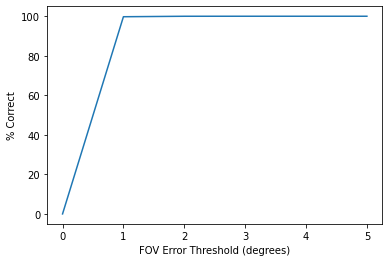

In [7]:
th_0 = 0
th_1 = 0
th_2 = 0
th_3 = 0
th_4 = 0
th_5 = 0

percent_correct = []

k = 55524

for i  in range(np.shape(output)[1]):
    
    predicted_fov = 2*np.arctan(112/(2*output[0][i][0]))
    actual_fov = 2*np.arctan(112/(2*Fx[k]))
    
    if abs(predicted_fov - actual_fov) <= 0:
        
        th_0 += 1 
        
    if abs(predicted_fov - actual_fov) <= 1:
        
        th_1 += 1
        
    if abs(predicted_fov - actual_fov) <= 2:
        
        th_2 += 1
        
    if abs(predicted_fov - actual_fov) <= 3:
        
        th_3 += 1
        
    if abs(predicted_fov - actual_fov) <= 4:
        
        th_4 += 1
        
    if abs(predicted_fov - actual_fov) <= 5:
        
        th_5 += 1
        
    k += 1

percent_correct.append(th_0/np.shape(output)[1]*100)
percent_correct.append(th_1/np.shape(output)[1]*100)
percent_correct.append(th_2/np.shape(output)[1]*100)
percent_correct.append(th_3/np.shape(output)[1]*100)
percent_correct.append(th_4/np.shape(output)[1]*100)
percent_correct.append(th_5/np.shape(output)[1]*100)

plt.plot([0,1,2,3,4,5],percent_correct)
plt.xlabel("FOV Error Threshold (degrees)")
plt.ylabel("% Correct")

In [8]:
th_0, th_1, th_2, th_3, th_4, th_5

(0, 23737, 23794, 23796, 23796, 23796)

In [9]:
th_0/np.shape(output)[1], th_1/np.shape(output)[1], th_2/np.shape(output)[1], th_3/np.shape(output)[1]

(0.0, 0.9975205916960834, 0.9999159522608841, 1.0)

In [10]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x)
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y)
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z)
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 1.7203366214287756, 'fy': 1.4489545759413487, 'u0': 0.1817660600242544, 'v0': 0.7168212601428754, 'baseline': 2.0212013848911194, 'disparity': 0.6347296211487513, 'x': 0.33405547099747485, 'y': 0.22606784079751763, 'z': 0.553045160380867, 'pitch': 17.526308870852585, 'xworld': 15.08453204150905, 'yworld': 1.7003544984662247, 'zworld': 16.06738446825849}


# Normalization

In [6]:

import math 

def normalize(x):
    
    return (math.atan(x) + 3.14/2) / 3.14

In [7]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += normalize(abs(predicted_fx - actual_fx))
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += normalize(abs(predicted_fy - actual_fy))
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += normalize(abs(predicted_u0 - actual_u0))
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += normalize(abs(predicted_v0 - actual_v0))
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += normalize(abs(predicted_baseline - actual_baseline))
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += normalize(abs(predicted_disparity - actual_disparity))
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += normalize(abs(predicted_tx - actual_tx))
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += normalize(abs(predicted_ty - actual_ty))
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += normalize(abs(predicted_tz - actual_tz))
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += normalize(abs(predicted_pitch - actual_pitch))
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += normalize(abs(predicted_x - actual_x))
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += normalize(abs(predicted_y - actual_y))
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += normalize(abs(predicted_z - actual_z))
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.8843963428617811, 'fy': 0.9114423831145054, 'u0': 0.7282263956665703, 'v0': 0.6373140539925413, 'baseline': 0.8732234974660816, 'disparity': 0.6210554186664111, 'x': 0.7347879211851821, 'y': 0.7188259027103718, 'z': 0.7334200235350675, 'pitch': 0.9524821243477615, 'xworld': 0.9656370923642681, 'yworld': 0.9002662165885574, 'zworld': 0.9758289870726622}


# Range Normalization

In [7]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

min_fx = 1.9073486e-06
max_fx = 3214.9907

min_fy = 2.9563904e-05
max_fy = 2051.209

min_u0 = 1.9073486e-05
max_u0 = 2178.9983

min_v0 = 3.8146973e-06
max_v0 = 2385.7239

min_baseline = 4.7683716e-06
max_baseline = 22.68721567997021

min_disparity = 9.536743e-07
max_disparity = 134.60031

min_tx = 2.384185791015625e-06
max_tx = 22.68721567997021

min_ty = 2.3841858e-07
max_ty = 33.11693576309983

min_tz = 2.3841858e-06
max_tz = 17.20185265614626

min_pitch = 4.57763671875e-05
max_pitch = 4502.9224

min_xw = 5.219264654243716e-06
max_xw = 386.4486

min_yw = 3.8146973e-06
max_yw = 1835.1849

min_zw = 0.00011349
max_zw = 339.17166

key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += (abs(predicted_fx - actual_fx) - min_fx)/(max_fx - min_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += (abs(predicted_fy - actual_fy) - min_fy)/(max_fy - min_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += (abs(predicted_u0 - actual_u0) - min_u0)/(max_u0 - min_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += (abs(predicted_v0 - actual_v0) - min_v0)/(max_v0 - min_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += (abs(predicted_baseline - actual_baseline) - min_baseline)/(max_baseline - min_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += (abs(predicted_disparity - actual_disparity) - min_disparity)/(max_disparity - min_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += (abs(predicted_tx - actual_tx) - min_tx)/(max_tx - min_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += (abs(predicted_ty - actual_ty) - min_ty)/(max_ty - min_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += (abs(predicted_tz - actual_tz) - min_tz)/(max_tz - min_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += (abs(predicted_pitch - actual_pitch) - min_pitch)/(max_pitch - min_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += (abs(predicted_x - actual_x) - min_xw)/(max_xw - min_xw)
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += (abs(predicted_y - actual_y) - min_yw)/(max_yw - min_yw)
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += (abs(predicted_z - actual_z) - min_zw)/(max_zw - min_zw)
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.02463748515183124, 'fy': 0.02831664666868909, 'u0': 0.02294115505902206, 'v0': 0.017306714223111433, 'baseline': 0.12978495358614217, 'disparity': 0.01774838413167217, 'x': 0.055404124404127224, 'y': 0.03276949154431778, 'z': 0.07197428159761873, 'pitch': 0.019904880198233815, 'xworld': 0.08421927624064439, 'yworld': 0.018279980683418177, 'zworld': 0.1307571785332731}


# Normalized MAE

In [11]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

mean_fx = 84.70939817976283

mean_fy = 84.70939817976283

mean_u0 = 56.0

mean_v0 = 56.0

mean_baseline = 3.1362834089762988

mean_disparity = 5.6359135359419765

mean_tx = 3.1362834089762988

mean_ty = 3.2890401748192972

mean_tz = 2.8612371827197847

mean_pitch = 84.54614220877458

mean_xw = 31.613377053172897

mean_yw = 25.092866140117593

mean_zw = 42.71013880363322


key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx) / mean_fx
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy) / mean_fy
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0) / mean_u0
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0) / mean_v0
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline) / mean_baseline
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity) / mean_disparity
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx) / mean_tx
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty) / mean_ty
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz) / mean_tz
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch) / mean_pitch
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x) / mean_xw
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y) / mean_yw
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z) / mean_zw
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.020308686620320718, 'fy': 0.017105003778522292, 'u0': 0.0032458225004331092, 'v0': 0.012800379645408429, 'baseline': 0.6444575063292809, 'disparity': 0.11262231350798388, 'x': 0.10651316460795186, 'y': 0.0687336817981936, 'z': 0.1932888205567041, 'pitch': 0.20729874140885132, 'xworld': 0.4771566168377753, 'yworld': 0.06776246639070894, 'zworld': 0.37619602554163734}
